<h1><b> Spatialisation : Interpolation des données du clients </h1></b>


Ce notebook présente l'utilisation du modèle bi-dimensionnel du champ pour une meilleure répartitions des observations d'humidité du sol.

In [31]:
%matplotlib inline
import sys
sys.path.append("../SOURCE")
import numpy as np
import matplotlib
matplotlib.style.use("ggplot")
import matplotlib.pyplot as plt
from spatial import Spatial_grid, HumidityData
import pandas as pd

np.random.seed(3)

On commence par lire et stocker des données d'humidité pour chacune des sondes du champ. Le format retenu pour cela est le ``csv``, plus simple que les types `xlsx`.

In [32]:
canons_data = []
for k in range(1, 7):
    canon = HumidityData(f'data/Data 2022/Probes/Sonde Canon {k}.csv')
    canon.read_data()
    canons_data.append(canon.get_humidity_values())


On stocke les données spatiales de la localisation des sondes en coordonnées (x,y) dans le champ.

Les coordonnées en z représentent l'humidité localement en (x,y) obtenue avec les mesures des sondes Canon : cela permettra de générer un graphe en surface.

In [33]:
coord_canon = {1:[0,0],2:[1,2],3:[4,2],4:[3,5],5:[2,2],6:[5,5]}
coord_x = [coord_canon[i][0] for i in coord_canon.keys()]
coord_y = [coord_canon[i][1] for i in coord_canon.keys()]

random_coords = [(np.random.uniform(0, 10), np.random.uniform(0, 10)) for _ in range(6)]

k = 1300
coord_z = [canons_data[i]['humidity6'][k] for i in range(6)]

In [34]:
print('Date : ',canons_data[1]['time'][k]) # date de la mesure

Date :  2022-07-25 18:00:00


La classe `Spatial_grid` permet d'effectuer multiples opérations spatiales à partir des données des coordonnées (x,y) des sondes et de l'humidité localement mesurée

## Interpolation linéaire

Une première approche d'estimer les valeurs d'humidité entre les sondes est l'interpolation linéaire qui forme des 'triangles' en traçant des droites entre les 3 sondes les plus prochent, ce qui forme une figure 3D de valeurs d'humidité entre les sondes.

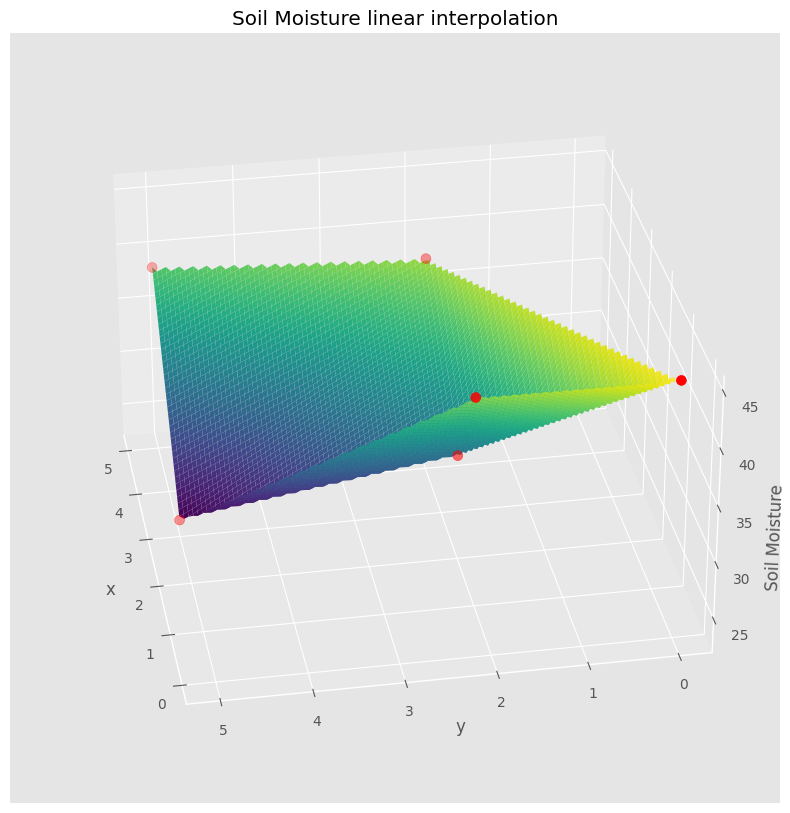

In [35]:
canon_grid_linear = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid_linear.plot(cmap='viridis', method='linear', azim= 170, elev= 30, color_bar=False, box_aspect=[1, 1, 0.6])

## Interpolation et Extrapolation des plus proches voisins

Le modèle linéaire est limité à l'interpolation et ne permet pas d'avoir de données externes à la zone délimitée par les sondes, sans quoi les quantités en jeu grandissent extrêmement vite.

Mais une extrapolation en plus de l'interpolation peut être faite avec le modèle Nearest-Neighbor qui forme des plateaux en attribuant à chaque coordonnées la valeur d'humidité de la sonde la plus proche

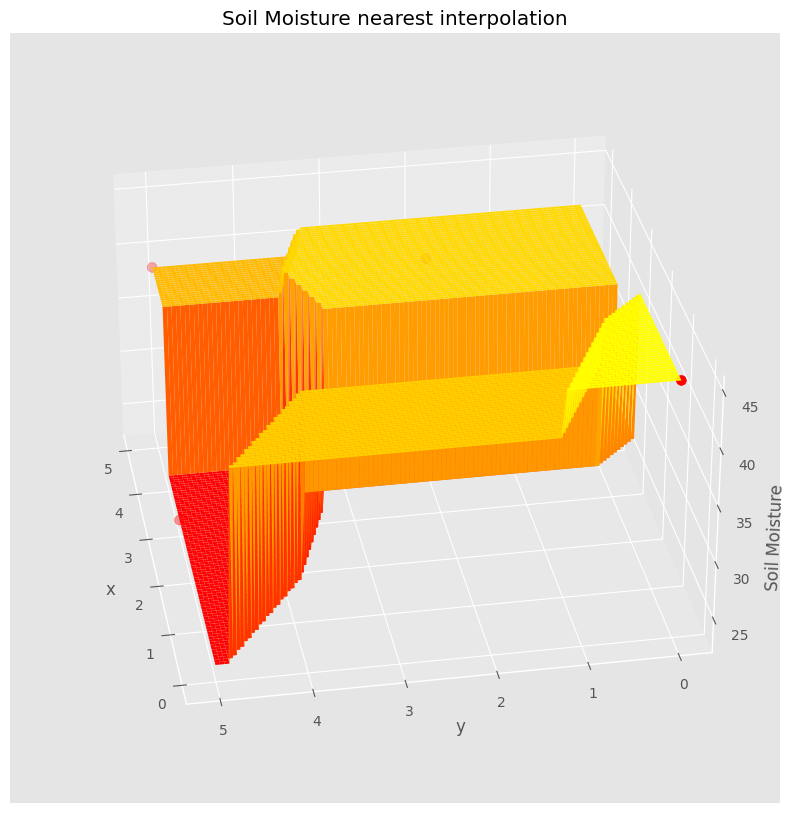

In [36]:
canon_grid_near = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid_near.plot(cmap='autumn', method='nearest', azim= 170, elev= 30, color_bar=False, box_aspect=[1, 1, 0.6])

## Combined Nearest Neighbor extrapolation and Linear Interpolation

En combinant le modèle linéaire et NN, on peut estimer une valeur d'humidité sur l'ensemble du champ malgré le peu de sondes disponibles.

Le modèle NN sert à extrapoler les valeurs en dehors de la zone délimitée par les sondes, qui est elle-même approximée par le modèle linéaire

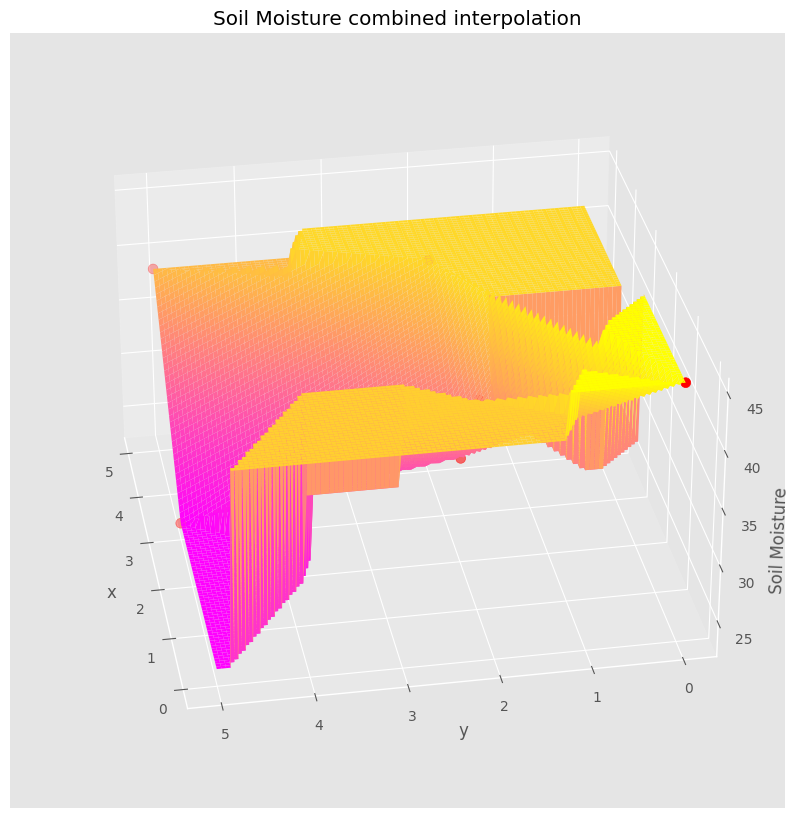

In [37]:
canon_grid = Spatial_grid(coord_x, coord_y, coord_z)
canon_grid.plot_lin_neigh(fig_size=(10, 12), cmap='spring', azim= 170, elev= 30, color_bar=False,box_aspect=[1, 1, 0.6])

In [38]:
canon_grid.cell_size() # Retrouver la taille des cellules en x,y sur lesquelles la data assimilation peut être faite, 
# taille arbitraire en raison du manque de vraies données de coordonnées sur les sondes
# 100x100 cells de 0.10x0.12 dans l'exemple

(0.05050505050505051, 0.05050505050505051)

Les données d'humidité relativement à la parcelle de champ considéré peuvent être récupérées avec la fonction get_values() qui retourne x,y,z avec pour toute cellule en x[i],y[j] l'humidité est de z[i,j]

In [39]:
x,y,z = canon_grid.get_values()

df = pd.DataFrame()
for i in range(len(x)):
    for j in range(len(y)):
        row = {'x': x[i], 'y': y[j], 'humidity': z[j, i]}
        df = pd.concat([df, pd.DataFrame(row, index=[0])], ignore_index=True)

In [40]:
df.iloc[2500:2520]

,x,y,humidity
2500,1.262626,0.000000,44.780000
2501,1.262626,0.050505,44.780000
2502,1.262626,0.101010,44.780000
2503,1.262626,0.151515,44.780000
2504,1.262626,0.202020,44.780000
2505,1.262626,0.252525,44.780000
2506,1.262626,0.303030,44.780000
2507,1.262626,0.353535,44.780000
2508,1.262626,0.404040,44.780000
2509,1.262626,0.454545,44.780000


## Mesure de l'humidité en fonction du temps dans le champ pour chaque parcelle de champ

A partir des interpolation et extrapolation précédentent l'humidité locale pour chacune des 100x100 parcelles de champ considérées ici peut être estimée. Les coordonnées choisies pour les sondes canon étant arbitraires dans l'exemple, la connaissance précise des coordonnées de chacune des sondes utilisées dans l'étude rendrait les résultats plus cohérent, mais le fonctionnement reste montré par l'exemple.

In [41]:
n = len(canons_data[0]['humidity1']) # nombre de mesures par sonde

In [42]:
coord_z_list = [[] for i in range(6)]
canon_grid_list = [[] for i in range(6)]
humidity_values = [[] for i in range(6)] 
for l in range(1,7):
    for k in range(n):
        coord_z_list[l-1].append([canons_data[i]['humidity'+str(l)][k] for i in range(6)])
        canon_grid_list[l-1].append(Spatial_grid(coord_x, coord_y, coord_z_list[l-1][k])) # interpolation pour chaque cellule est chaque profondeur d'humidité
        humidity_values[l-1].append(canon_grid_list[l-1][k].get_values()[2])

In [43]:
cell_coord = (70,70) # cellule choisie parmis le 100x100 cellules
humidity_values[0][1000][cell_coord]

11.584680134680134

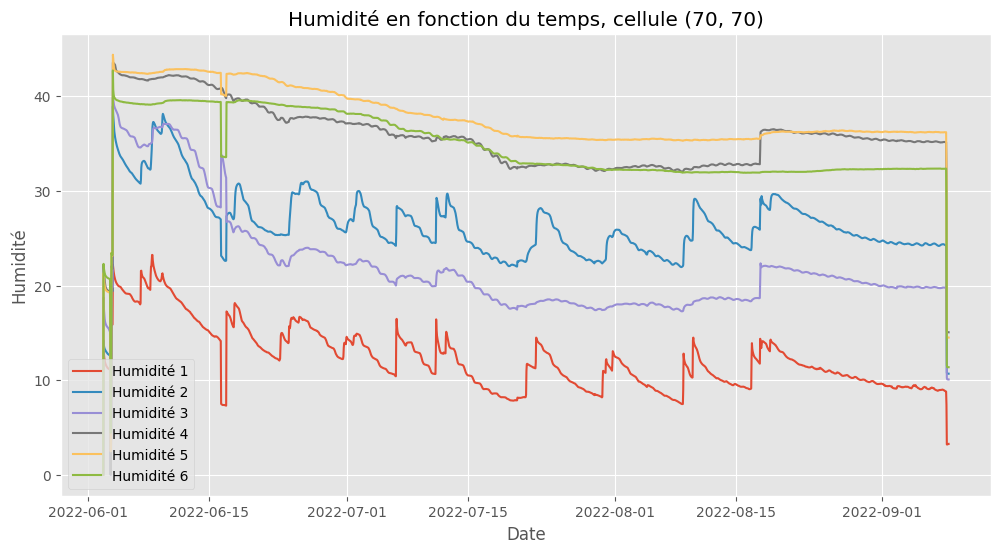

In [44]:
plt.figure(figsize=(12, 6))

for i in range(6):
    plt.plot(canons_data[0]['time'],[humidity_values[i][k][cell_coord] for k in range(n)], label=f'Humidité {i+1}')
    plt.xlabel('Date')
    plt.ylabel('Humidité')
    plt.title('Humidité en fonction du temps, cellule {}'.format(cell_coord))
    plt.legend()
plt.show()

### Mesures des sondes 

On trace les données des sondes pour comparer les données disponibles à l'assimilation: on constate un manque de données d'humidité su la période entre fin juin et le premier juillet.

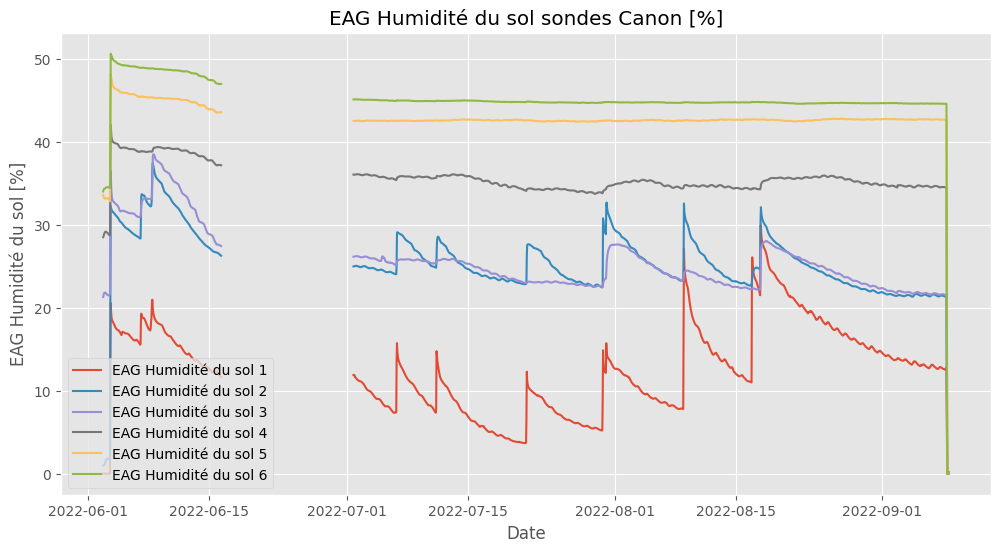

In [45]:
plt.figure(figsize=(12, 6))
i = 1
for k in range(1,7):
    plt.plot(canons_data[0]['time'], canons_data[0]['humidity'+str(k)], label = 'EAG Humidité du sol '+str(k))

plt.title("EAG Humidité du sol sondes Canon [%]")
plt.xlabel('Date')
plt.legend()
plt.ylabel("EAG Humidité du sol [%]")
plt.grid(True)
plt.show()
